In [1]:
import os
import pandas as pd
import spacy
from spacy.tokens import Doc
from tqdm import tqdm_notebook as tqdm
import pickle
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

import kenlm

# Measure 'markedness'/heteronormativity

## Language model perplexity of lgbtq set vs bg over time

### Construct lm input text

In [17]:
# Load background data
bg_data = pd.read_pickle('/usr0/home/mamille2/11-830_data/hw1/background_news_corpus.pkl')
print(bg_data.columns)
len(bg_data)

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category', 'toks'], dtype='object')


34433

In [58]:
pd.set_option('display.max_colwidth', 999)

In [61]:
doclines = []
for toks in bg_data['toks'].tolist():
    doclines.append(' '.join(toks))
    
doclines[:2]

['union township the karl and helen burger gallery at kean university \x89ûïw . carl burger , drawing for 50 years,\x89û\x9d exhibition . through july 19.mondays through thursdays , 11 a.m. to 5 p.m. the karl and helen burger gallery at kean university , 1000 morris avenue . ( 908 ) 737 - 0392 ; kean.edu/~gallery .',
 'in his view , the european union \x89ûó for all its faults \x89ûó has stepped into a historical role once played , for better or for worse , by the austro - hungarian empire and later , the yugoslav federation , before they fell apart under the strain of war , nationalist politics and hatred .']

In [64]:
with open('/usr0/home/mamille2/11-830_data/hw1/bg_text.txt', 'w') as f:
    for l in doclines:
        f.write(l+'\n')

In [74]:
# Separate by date

bg_yr = {}
date_bins = {'1986-1995': range(1986,1996),
            '1996-2005': range(1996,2006),
            '2006-2015': range(2006,2016)}

for db in date_bins:
    bg_yr[db] = bg_data[bg_data['Date'].map(lambda x: int(x[:4]) in date_bins[db])]
    print(len(bg_yr[db]))

11540
11540
11353


In [76]:
doclines_yr = {}
for db in date_bins:
    doclines_yr[db] = []
    
    for toks in bg_yr[db]['toks'].tolist():
        doclines_yr[db].append(' '.join(toks))
    
len(doclines_yr)

3

In [77]:
for db in date_bins:
    with open(f'/usr0/home/mamille2/11-830_data/hw1/bg_text_{db}.txt', 'w') as f:
        for l in doclines_yr[db]:
            f.write(l+'\n')

In [ ]:
# Sentences
sentlines_yr

In [91]:
sentlines_yr = {}
for db in date_bins:
    sentlines_yr[db] = []
    
    for toks in bg_yr[db]['toks'].tolist():
        doc = ' '.join(toks)
        for sent in doc.split(' . '):
            sentlines_yr[db].append(sent)
    
len(sentlines_yr)

3

In [92]:
for db in date_bins:
    with open(f'/usr0/home/mamille2/11-830_data/hw1/bg_text_{db}.txt', 'w') as f:
        for l in sentlines_yr[db]:
            f.write(l+'\n')

### Get scores from the language model

In [95]:
# model = kenlm.Model('/usr0/home/mamille2/11-830_data/hw1/bg_text.binary')
models_yr = {}

for db in date_bins:
    models_yr[db] = kenlm.Model(f'/usr0/home/mamille2/11-830_data/hw1/bg_text_{db}.arpa')

In [93]:
# Get sentences
lgbtq_sents = {}

for db in date_bins:
    lgbtq_sents[db] = []
    for toks in data_yr[db]['toks'].tolist():
        doc = ' '.join(toks)
        for sent in doc.split(' . '):
            lgbtq_sents[db].append(sent)
            
len(lgbtq_sents)

3

In [67]:
lgbtq_yr = {db: [' '.join(toks) for toks in data_yr[db]['toks'].tolist()] for db in date_bins}
len(lgbtq_yr)

3

In [96]:
# Calculate avg log-likelihood across time periods

ll_yr = {}
for db in date_bins:
    ll_yr[db] = np.mean([models_yr[db].score(doc) for doc in lgbtq_sents[db]])
    
ll_yr

{'1986-1995': -55.7813292290585,
 '1996-2005': -59.095251339945101,
 '2006-2015': -62.852244550250226}

In [94]:
# Lengths of sentences by year
means = {}

for db in date_bins:
    print(db)
    means[db] = np.mean([len(d.split()) for d in lgbtq_sents[db]])
    print(means[db])
    print(np.std([len(d.split()) for d in lgbtq_sents[db]]))
    print()

1986-1995
19.9038380639
15.0831472739

1996-2005
21.4726192267
22.87879062

2006-2015
22.5195241579
17.263624355



In [98]:
for db in date_bins:
    print(db)
    print(ll_yr[db]/means[db])

1986-1995
-2.80254135157
1996-2005
-2.75212123477
2006-2015
-2.79101121806


In [88]:
# Lengths of documents by year
means = {}

for db in date_bins:
    print(db)
    means[db] = np.mean([len(d) for d in data_yr[db]['toks'].tolist()])
    print(means[db])
    print(np.std([len(d) for d in data_yr[db]['toks'].tolist()]))
    print()

1986-1995
73.0624783362
133.533875888

1996-2005
77.2449740035
148.601485276

2006-2015
74.426169844
141.007752684



In [89]:
for db in date_bins:
    print(ll_yr[db]/means[db])

-2.66976348526
-2.63911537346
-2.69700595719


In [73]:
# Calculate lm perplexity
ppl_yr = {db: 2**(-1*ll_yr[db]) for db in date_bins}
ppl_yr

{'1986-1995': 1.1310640698050026e+57,
 '1996-2005': 1.1976248831780374e+59,
 '2006-2015': 4.4320419664614882e+58}

## More mentions of opposite terms

In [2]:
binaries = [
    ('gay', 'straight'), 
    ('transgender', 'cisgender'),
    ('homosexual', 'heterosexual')
           ]

In [3]:
# Load LGBTQ corpus
lgbtq_data = pd.read_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')
print(lgbtq_data.columns)
print(len(lgbtq_data))

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'toks', 'spacy_toks',
       'toks_nopunct', 'pos', 'tok_pos'],
      dtype='object')
34620


In [4]:
# Build token counter
toks = [t for d in lgbtq_data['toks'].tolist() for t in d]
print(len(toks))

toks_ctr = Counter(toks)
print(len(toks_ctr))

2593426
74752


In [6]:
# Get overall term frequencies

freqs = {}

for t0, t1 in binaries:
    freqs[(t0, t1)] = (toks_ctr[t0], toks_ctr[t1])
    
freqs

{('gay', 'straight'): (27207, 778),
 ('homosexual', 'heterosexual'): (4318, 1062),
 ('transgender', 'cisgender'): (982, 4)}

### Explore by year

In [7]:
data_yr = {}
date_bins = {'1986-1995': range(1986,1996),
            '1996-2005': range(1996,2006),
            '2006-2015': range(2006,2016)}

for db in date_bins:
    data_yr[db] = lgbtq_data[lgbtq_data['Date'].map(lambda x: int(x[:4]) in date_bins[db])]
    print(len(data_yr[db]))

11540
11540
11540


In [8]:
toks_yr = {}
for db in date_bins:
    toks_yr[db] = Counter([t for d in data_yr[db]['toks'].tolist() for t in d])
    
len(toks_yr)

3

In [10]:
# Get term frequencies by year
freqs_yr = {}

for db in date_bins:
    freqs_yr[db] = {}
    for t0, t1 in binaries:
        freqs_yr[db][(t0, t1)] = (toks_yr[db][t0], toks_yr[db][t1])
    
freqs_yr

{'1986-1995': {('gay', 'straight'): (7683, 131),
  ('homosexual', 'heterosexual'): (3067, 482),
  ('transgender', 'cisgender'): (7, 0)},
 '1996-2005': {('gay', 'straight'): (10315, 299),
  ('homosexual', 'heterosexual'): (942, 339),
  ('transgender', 'cisgender'): (121, 0)},
 '2006-2015': {('gay', 'straight'): (9209, 348),
  ('homosexual', 'heterosexual'): (309, 241),
  ('transgender', 'cisgender'): (854, 4)}}

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


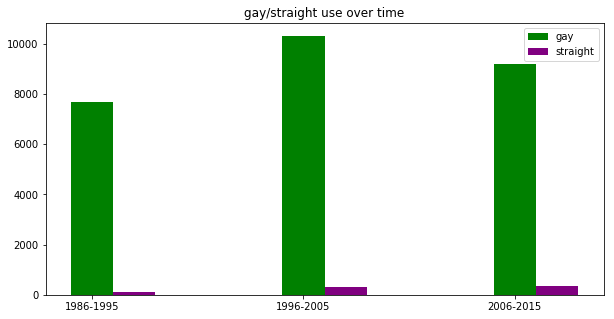

In [13]:
# Graph binaries frequencies by year

binary = ('gay', 'straight')

comparison = {
    binary[0]: [freqs_yr[db][binary][0] for db in sorted(date_bins.keys())],
    binary[1]: [freqs_yr[db][binary][1] for db in sorted(date_bins.keys())]
}

x = np.array(range(len(comparison[binary[0]])))

plt.figure(figsize=(10,5))
plt.title(f"{binary[0]}/{binary[1]} use over time")
labels = sorted(date_bins.keys())
ax = plt.subplot(111)
ax.bar(x, comparison[binary[0]], width=0.2,color='g',align='center')
ax.bar(x+0.2, comparison[binary[1]], width=0.2,color='purple',align='center')
ax.legend(binary)

plt.xticks(x,labels)
plt.savefig(f'/usr0/home/mamille2/11-830_data/hw1/{binary[0]}_{binary[1]}_time.png', dpi=200)
plt.show()

In [20]:
# Get term ratios by year
ratio_yr = {}

for db in date_bins:
    ratio_yr[db] = {}
    for t0, t1 in binaries:
        ratio_yr[db][(t0, t1)] = toks_yr[db][t1]/toks_yr[db][t0]
    
ratio_yr

{'1986-1995': {('gay', 'straight'): 0.017050631263829233,
  ('homosexual', 'heterosexual'): 0.15715683077926312,
  ('transgender', 'cisgender'): 0.0},
 '1996-2005': {('gay', 'straight'): 0.02898691226369365,
  ('homosexual', 'heterosexual'): 0.35987261146496813,
  ('transgender', 'cisgender'): 0.0},
 '2006-2015': {('gay', 'straight'): 0.03778911933977631,
  ('homosexual', 'heterosexual'): 0.7799352750809061,
  ('transgender', 'cisgender'): 0.00468384074941452}}

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


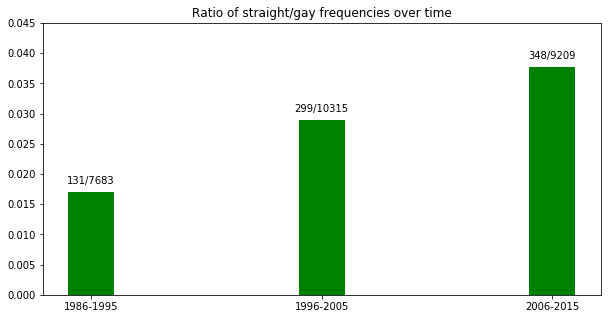

In [46]:
%matplotlib inline
# Graph binaries frequencies by year

binary = binaries[0]

comparison = [ratio_yr[db][binary] for db in sorted(date_bins.keys())]
compseries = pd.Series.from_array(comparison)

x = np.array(range(len(comparison)))

plt.figure(figsize=(10,5))
plt.title(f"Ratio of {binary[1]}/{binary[0]} frequencies over time")
labels = sorted(date_bins.keys())
ax = plt.subplot(111)
# ax = compseries.plot(kind='bar')
ax.bar(x, comparison, width=0.2,color='g',align='center')
# ax.bar(x+0.2, comparison[binary[1]], width=0.2,color='purple',align='center')
# ax.legend(binary)

# Now make some labels
rects = ax.patches
top_labels = [f'{freqs_yr[db][binary][1]}/{freqs_yr[db][binary][0]}' for db in date_bins]

for rect, tlabel in zip(rects, top_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + .001, tlabel, ha='center', va='bottom')

ax.set_ylim(top=0.045)
plt.xticks(x,labels)
plt.savefig(f'/usr0/home/mamille2/11-830_data/hw1/{binary[0]}_{binary[1]}_ratio.png', dpi=200)
plt.show()

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


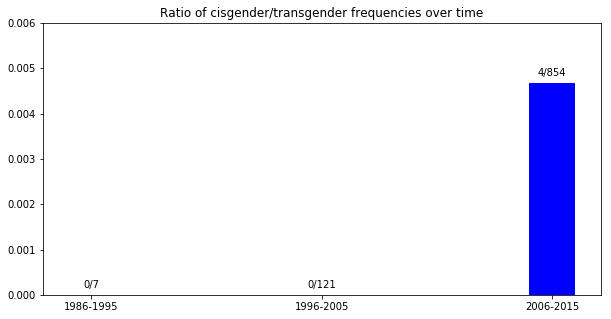

In [52]:
%matplotlib inline
# Graph binaries frequencies by year

binary = binaries[1]

comparison = [ratio_yr[db][binary] for db in sorted(date_bins.keys())]
compseries = pd.Series.from_array(comparison)

x = np.array(range(len(comparison)))

plt.figure(figsize=(10,5))
plt.title(f"Ratio of {binary[1]}/{binary[0]} frequencies over time")
labels = sorted(date_bins.keys())
ax = plt.subplot(111)
# ax = compseries.plot(kind='bar')
ax.bar(x, comparison, width=0.2,color='b',align='center')
# ax.bar(x+0.2, comparison[binary[1]], width=0.2,color='purple',align='center')
# ax.legend(binary)

# Now make some labels
rects = ax.patches
top_labels = [f'{freqs_yr[db][binary][1]}/{freqs_yr[db][binary][0]}' for db in date_bins]

for rect, tlabel in zip(rects, top_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + .0001, tlabel, ha='center', va='bottom')

ax.set_ylim(top=0.006)
plt.xticks(x,labels)
plt.savefig(f'/usr0/home/mamille2/11-830_data/hw1/{binary[0]}_{binary[1]}_ratio.png', dpi=200)
plt.show()

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


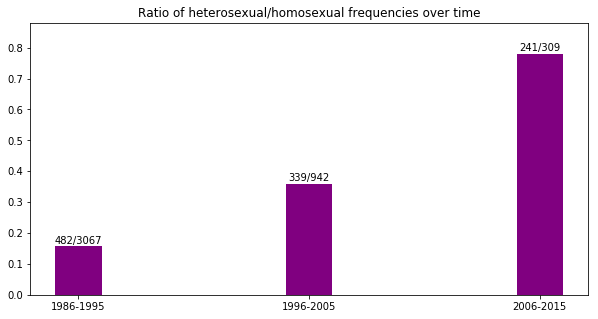

In [55]:
%matplotlib inline
# Graph binaries frequencies by year

binary = binaries[2]

comparison = [ratio_yr[db][binary] for db in sorted(date_bins.keys())]
compseries = pd.Series.from_array(comparison)

x = np.array(range(len(comparison)))

plt.figure(figsize=(10,5))
plt.title(f"Ratio of {binary[1]}/{binary[0]} frequencies over time")
labels = sorted(date_bins.keys())
ax = plt.subplot(111)
# ax = compseries.plot(kind='bar')
ax.bar(x, comparison, width=0.2,color='purple',align='center')
# ax.bar(x+0.2, comparison[binary[1]], width=0.2,color='purple',align='center')
# ax.legend(binary)

# Now make some labels
rects = ax.patches
top_labels = [f'{freqs_yr[db][binary][1]}/{freqs_yr[db][binary][0]}' for db in date_bins]

for rect, tlabel in zip(rects, top_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + .002, tlabel, ha='center', va='bottom')

ax.set_ylim(top=max(comparison)+0.1)
plt.xticks(x,labels)
plt.savefig(f'/usr0/home/mamille2/11-830_data/hw1/{binary[0]}_{binary[1]}_ratio.png', dpi=200)
plt.show()

# Explore sentiment

In [2]:
# Load sentiment lexica
sent_path = '/usr0/home/mamille2/11-830_data/sentiment_subjectivity_lexicons.csv'
sent_data = pd.read_csv(sent_path, header=0, skiprows=[1])
sent_data

,Negative sentiment,Positive sentiment,Subjectivity lexicon,Negative emotion,Negative lexicon
0,abnormal,a+,abase,abandon,abandon*
1,abolish,abound,abasement,abandoned,abandon*
2,abominable,abounds,abash,abandonment,abuse*
3,abominably,abundance,aberration,abduction,abuse*
4,abominate,abundant,abhor,aberrant,abusi*
5,abomination,accessable,abhorred,aberration,abusi*
6,abort,accessible,abhorrence,abhor,ache*
7,aborted,acclaim,abhorrent,abhorrent,ache*
8,aborts,acclaimed,abhorrently,abject,aching
9,abrade,acclamation,abhors,abnormal,aching


In [8]:
subj_terms = {}
for col in sent_data.columns:
#     subj_terms[col] = [r'\b{}\b'.format(wd).replace('*', '.*') for wd in sent_data[col].tolist() if isinstance(wd, str)]
    subj_terms[col] = [wd for wd in sent_data[col].tolist() if isinstance(wd, str)]
    
len(subj_terms)

5

## Graph diffs

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


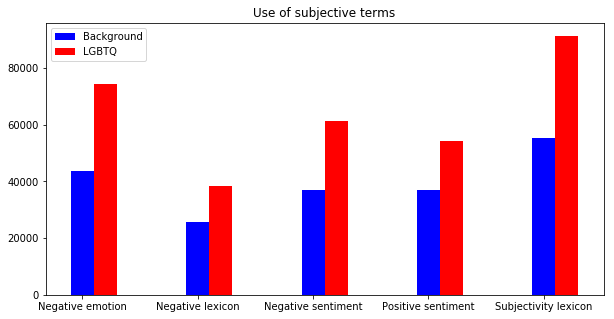

In [22]:
# comparison = {
#     'Negative emotion': [43497, 74318],
#     'Negative lexicon': [5702,7686],
#     'Negative sentiment': [36782,61404],
#     'Positive sentiment': [36877,54367],
#     'Subjectivity lexicon': [55306,91285]
# }

comparison = {
    'Background': [43497, 25614, 36782, 36877, 55306],
    'LGBTQ': [74318, 38366, 61404, 54367, 91285]
}

x = np.array(range(len(comparison['Background'])))

plt.figure(figsize=(10,5))
plt.title("Use of subjective terms")
labels = ['Negative emotion', 'Negative lexicon', 'Negative sentiment', 'Positive sentiment', 'Subjectivity lexicon']
ax = plt.subplot(111)
ax.bar(x, comparison['Background'], width=0.2,color='b',align='center')
ax.bar(x+0.2, comparison['LGBTQ'], width=0.2,color='r',align='center')
ax.legend(['Background', 'LGBTQ'])

plt.xticks(x,labels)
plt.savefig('/usr0/home/mamille2/11-830_data/subjectivity_diff.png', dpi=200)
plt.show()

## LGBTQ corpus

In [5]:
# Load LGBTQ corpus
lgbtq_data = pd.read_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')
print(lgbtq_data.columns)
print(len(lgbtq_data))

Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'toks', 'spacy_toks',
       'toks_nopunct', 'pos', 'tok_pos'],
      dtype='object')
34620


In [6]:
# Build token counter
toks = [t for d in lgbtq_data['toks'].tolist() for t in d]
print(len(toks))

2593426


In [7]:
toks_ctr = Counter(toks)
len(toks_ctr)

74752

In [12]:
subj_cts = {}

for typ in tqdm(subj_terms): 
#     subj_cts[typ] = {wd: toks_ctr[wd] for wd in subj_terms[typ]}
    subj_cts[typ] = {}
    for wd in subj_terms[typ]:
        if wd[-1] == '*':
            matches = [w for w in toks_ctr if w.startswith(wd[:-1])]
            
            for m in matches:
                subj_cts[typ][m] = toks_ctr[m]
            
        else:
            if wd in toks_ctr:
                 subj_cts[typ][wd] = toks_ctr[wd]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [13]:
subj_cts['Negative lexicon']

{'abandoned': 58,
 'abandoning': 17,
 'abandons': 2,
 'abandon': 43,
 'abandonment': 4,
 'abuse': 234,
 'abusers': 104,
 'abused': 43,
 'abuses': 27,
 'abuseamerican': 1,
 'abusemilitary': 1,
 'abused\x89û\x9d': 1,
 'abuse.\x89û\x9d': 1,
 'abuser': 5,
 'abusive': 22,
 'abusive,\\"\\': 3,
 'abusing': 16,
 'abusively': 1,
 'ache': 1,
 'acheson': 1,
 'achebe': 1,
 'aching': 1,
 'adversity': 4,
 'adversely': 7,
 'adverse': 11,
 'adversaries': 4,
 'adversarial': 3,
 'adversary': 4,
 'afraid': 113,
 'aggravated': 6,
 'aggravates': 1,
 'aggravate': 1,
 'aggressively': 36,
 "aggressive'z": 1,
 'aggressor': 4,
 'aggressiveness': 4,
 'aggressive': 67,
 'aggression': 11,
 'aggressive\x89û\x9d': 1,
 'aggressors': 4,
 'aggressive.\x89û\x9d': 1,
 'aggressor.\\': 1,
 'aggressions': 1,
 'agitation': 5,
 'agitated': 4,
 'agitator': 1,
 'agitating': 3,
 'agitators': 1,
 'agonizingly': 2,
 'agonized': 4,
 'agonizing': 3,
 'agony': 8,
 'alarmed': 23,
 'alarm': 21,
 'alarming': 26,
 'alarms': 8,
 'alarming

In [14]:
subj_sums = {typ: sum(subj_cts[typ].values()) for typ in subj_cts}
subj_sums

{'Negative emotion ': 74318,
 'Negative lexicon': 38366,
 'Negative sentiment': 61404,
 'Positive sentiment': 54367,
 'Subjectivity lexicon': 91285}

In [19]:
subj_sums = {typ: sum(subj_cts[typ].values()) for typ in subj_cts}
subj_sums

{'Negative emotion ': 74318,
 'Negative lexicon': 7686,
 'Negative sentiment': 61404,
 'Positive sentiment': 54367,
 'Subjectivity lexicon': 91285}

## Background corpus

In [18]:
# Build token counter
toks = [t for d in bg_data['toks'].tolist() for t in d]
print(len(toks))

1745328


In [19]:
toks_ctr = Counter(toks)
len(toks_ctr)

73844

In [34]:
subj_cts = {}

for typ in subj_terms: 
    subj_cts[typ] = {wd: toks_ctr[wd] for wd in subj_terms[typ]}

In [20]:
subj_cts = {}

for typ in tqdm(subj_terms): 
#     subj_cts[typ] = {wd: toks_ctr[wd] for wd in subj_terms[typ]}
    subj_cts[typ] = {}
    for wd in subj_terms[typ]:
        if wd[-1] == '*':
            matches = [w for w in toks_ctr if w.startswith(wd[:-1])]
            
            for m in matches:
                subj_cts[typ][m] = toks_ctr[m]
            
        else:
            if wd in toks_ctr:
                 subj_cts[typ][wd] = toks_ctr[wd]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [21]:
subj_sums = {typ: sum(subj_cts[typ].values()) for typ in subj_cts}
subj_sums

{'Negative emotion ': 43497,
 'Negative lexicon': 25614,
 'Negative sentiment': 36782,
 'Positive sentiment': 36877,
 'Subjectivity lexicon': 55306}

In [35]:
subj_sums = {typ: sum(subj_cts[typ].values()) for typ in subj_cts}
subj_sums

{'Negative emotion ': 43497,
 'Negative lexicon': 5702,
 'Negative sentiment': 36782,
 'Positive sentiment': 36877,
 'Subjectivity lexicon': 55306}

### Lowercase, tokenize background corpus

In [22]:
# Load data
bg_data = pd.read_csv('/usr0/home/mamille2/11-830_data/hw1/background_news_corpus.csv', encoding='ISO-8859-1')
print(len(bg_data))
print(bg_data.columns)

34620
Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category'], dtype='object')


In [23]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [26]:
doc_toks = [nlp(doc.lower()) for doc in tqdm(bg_data['Text'].tolist()) if isinstance(doc, str)]
len(doc_toks)

HBox(children=(IntProgress(value=0, max=34620), HTML(value='')))

34433

In [29]:
# Filter out NaN texts
bg_data = bg_data[bg_data['Text'].map(lambda x: isinstance(x, str))]
len(bg_data)

34433

In [30]:
bg_data['toks'] = [[tok.text for tok in doc] for doc in doc_toks]
bg_data['toks'].head()

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    [union, township, the, karl, and, helen, burge...
1    [in, his, view, ,, the, european, union, ûó, ...
2    [potential, overseas, researchers, and, teache...
3    [perhaps, ,, however, ,, it, is, time, to, loo...
4    [it, is, also, east, of, church, street, ,, on...
Name: toks, dtype: object

In [31]:
# Save data
bg_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/background_news_corpus.pkl')

# Make word clouds of context

## Get context

In [3]:
# seed_path = '/home/michael/school/11-830/hw1/seed_words.txt'
seed_path = '/usr0/home/mamille2/11-830_data/hw1/seed_words.txt'
custom = ['homosexual', 'homosexuals']
with open(seed_path) as f:
    seed = [l.lower() for l in f.read().splitlines()] + custom
    
seed

['agender',
 'androgyny',
 'androgynyous',
 'bisexual',
 'bigender',
 'butch',
 'cisgender',
 'gay',
 'gays',
 'gender-fluid',
 'genderqueer',
 'lesbian',
 'lesbians',
 'lgbt',
 'lgbtq',
 'queer',
 'transgender',
 'same-sex',
 'homosexual',
 'homosexuals']

In [4]:
# Load preprocessed data
lgbtq_data = pd.read_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')
print(len(lgbtq_data))
print(lgbtq_data.columns)

34620
Index(['Text', 'Title', 'Id', 'Count', 'Date', 'Category', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'toks', 'spacy_toks',
       'toks_nopunct'],
      dtype='object')


In [29]:
def get_context(toks):
    inds = [i for i in range(len(toks)) if toks[i] in seed]
    if inds:
        for i in inds:
            before_toks = [t for t in toks[max(0,i-3) : i] if not t in seed]
            after_toks = [t for t in toks[i+1 : min(len(toks)-1, i+4)] if not t in seed]

        return before_toks + after_toks
    
    else:
        return []

In [18]:
def get_context_pos(tuples):
    inds = [i for i in range(len(tuples)) if tuples[i][0] in seed and not tuples[i][0] in string.punctuation]
    if inds:
        for i in inds:
            before_tuples = [t for t in tuples[max(0,i-3) : i] if not t in seed]
            after_tuples = [t for t in tuples[i+1 : min(len(tuples)-1, i+4)] if not t in seed]

        return before_tuples + after_tuples
    
    else:
        return []

In [42]:
rm_list = ['\x89û', '\x9d']

In [30]:
context = [get_context(toks) for toks in lgbtq_data['toks_nopunct'].tolist()]
context = [c for c in context if len(c)>0]
context = [t for d in context for t in d]
context = ' '.join(context)

In [43]:
# Remove badlist
for el in rm_list:
    context = context.replace(el, '')

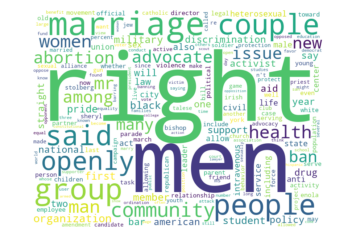

In [47]:
wordcloud = WordCloud(height=600, width=800, collocations=False, background_color='white').generate(context)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('/usr0/home/mamille2/11-830_data/lgbtq_context_overall.png', dpi=200)

## Divide by postag

In [7]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [11]:
lgbtq_data['spacy_toks'] = [nlp(doc.lower()) for doc in tqdm(lgbtq_data['Text'].tolist())]
lgbtq_data['spacy_toks'].head()

HBox(children=(IntProgress(value=0, max=34620), HTML(value='')))

0    (re, ûïobama, alters, hospital, rules, for, g...
1    (you, can, not, have, people, who, have, no, e...
2    (in, an, interview, with, tracy, clark, -, flo...
3    (after, we, filed, back, out, into, the, tenne...
4    (', ', gays, and, lesbians, are, a, very, good...
Name: spacy_toks, dtype: object

In [14]:
# Get postags
lgbtq_data['pos'] = [[tok.tag_ for tok in doc] for doc in tqdm(lgbtq_data['spacy_toks'].tolist())]

HBox(children=(IntProgress(value=0, max=34620), HTML(value='')))

In [25]:
# Get postags
lgbtq_data['tok_pos'] = [[(tok.text, tok.tag_) for tok in doc] for doc in tqdm(lgbtq_data['spacy_toks'].tolist())]

HBox(children=(IntProgress(value=0, max=34620), HTML(value='')))

In [17]:
# Save data
lgbtq_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')

In [36]:
def get_context_pos(tuples):
    inds = [i for i in range(len(tuples)) if tuples[i][0] in seed]
    if inds:
        for i in inds:
            before_tuples = [t for t in tuples[max(0,i-3) : i] if not t[0] in seed]
            after_tuples = [t for t in tuples[i+1 : min(len(tuples)-1, i+4)] if not t[0] in seed]

        return before_tuples + after_tuples
    
    else:
        return []

In [37]:
context_pos = [get_context_pos(tuples) for tuples in lgbtq_data['tok_pos_nopunct'].tolist()]
context_pos = [c for c in context_pos if len(c)>0]
context_pos = [t for d in context_pos for t in d]
print(len(context_pos))

context_pos[:100]

163710


[('hospital', 'NN'),
 ('rules', 'NNS'),
 ('for', 'IN'),
 ('rights\x89û\x9d', 'CD'),
 ('front', 'JJ'),
 ('page', 'NN'),
 ('the', 'DT'),
 ('community', 'NN'),
 ('the', 'DT'),
 ('segment', 'NN'),
 ('black', 'JJ'),
 ('the', 'DT'),
 ('a', 'DT'),
 ('mecca', 'NN'),
 ('for', 'IN'),
 ('\x89ûó', 'NNP'),
 ('though', 'IN'),
 ('that\x89ûªs', 'NN'),
 ('and', 'CC'),
 ('are', 'VBP'),
 ('a', 'DT'),
 ('very', 'RB'),
 ('the', 'DT'),
 ('spectrum', 'NN'),
 ('of', 'IN'),
 ('political', 'JJ'),
 ('go', 'VB'),
 ('to', 'IN'),
 ('a', 'DT'),
 ('web', 'NN'),
 ('site', 'NN'),
 ('and', 'CC'),
 ('means', 'VBZ'),
 ('is', 'VBZ'),
 ('that', 'IN'),
 ('scouts', 'NNS'),
 ('and', 'CC'),
 ('leaders', 'NNS'),
 ('document', 'NN'),
 ('will', 'MD'),
 ('bar', 'VB'),
 ('men', 'NNS'),
 ('even', 'RB'),
 ('those', 'DT'),
 ('director', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('men', 'NNS'),
 ("'s", 'POS'),
 ('health', 'NN'),
 ('men', 'NNS'),
 ('and', 'CC'),
 ('to', 'TO'),
 ('marry', 'VB'),
 ('and', 'CC'),
 ('human', 'JJ'),
 ('rights', 

In [38]:
# Adjectives
context_by_pos = {}
pos_types = {'adj': ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'], 
             'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
            'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']}

for pos in pos_types:
    context_by_pos[pos] = ' '.join([tok for tok,tag in context_pos if tag in pos_types[pos]])
#     print(len(context_by_pos[pos]))

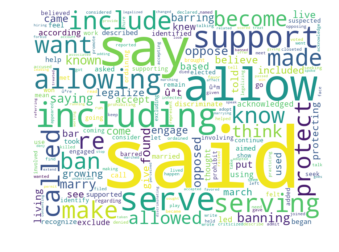

In [39]:
for pos in pos_types:
    wordcloud = WordCloud(height=600, width=800, collocations=False, background_color='white').generate(context_by_pos[pos])

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'/usr0/home/mamille2/11-830_data/lgbtq_context_{pos}.png', dpi=200)

## Divide by year

In [41]:
lgbtq_data['Date']

0        2010-04-26T00:00:00Z
1        1992-06-28T00:00:00Z
2        2014-09-24T15:44:50Z
3        2014-08-24T00:00:00Z
4        2004-02-29T00:00:00Z
5        1994-01-24T00:00:00Z
6        2004-04-26T00:00:00Z
7        2007-06-20T00:00:00Z
8        2012-07-17T16:50:14Z
9        2005-09-23T00:00:00Z
10       1987-06-07T00:00:00Z
11       2008-07-16T00:00:00Z
12       2012-05-06T11:02:19Z
13       2007-11-20T07:30:42Z
14       2015-06-27T00:00:00Z
15       2011-02-06T18:39:10Z
16       2015-06-30T00:00:00Z
17       2004-11-16T00:00:00Z
18       2012-11-13T00:00:00Z
19       2005-02-14T00:00:00Z
20       2011-07-17T00:00:00Z
21       2010-03-30T00:00:00Z
22       2008-06-09T00:00:00Z
23       2000-12-24T00:00:00Z
24       2012-01-26T21:15:45Z
25       1986-12-21T00:00:00Z
26       2012-01-04T14:38:40Z
27       2006-04-10T00:00:00Z
28       2012-11-25T17:59:50Z
29       2012-05-13T00:00:00Z
                 ...         
34590    1986-02-09T00:00:00Z
34591    1986-04-06T00:00:00Z
34592    1

In [46]:
len(lgbtq_data)

34620

In [45]:
data_yr = {}
date_bins = {'1986-1995': range(1986,1996),
            '1996-2005': range(1996,2006),
            '2006-2015': range(2006,2016)}

for db in date_bins:
    data_yr[db] = lgbtq_data[lgbtq_data['Date'].map(lambda x: int(x[:4]) in date_bins[db])]
    print(len(data_yr[db]))

11540
11540
11540


In [47]:
def get_context(toks):
    inds = [i for i in range(len(toks)) if toks[i] in seed]
    if inds:
        for i in inds:
            before_toks = [t for t in toks[max(0,i-3) : i] if not t in seed]
            after_toks = [t for t in toks[i+1 : min(len(toks)-1, i+4)] if not t in seed]

        return before_toks + after_toks
    
    else:
        return []

In [48]:
rm_list = ['\x89û', '\x9d']

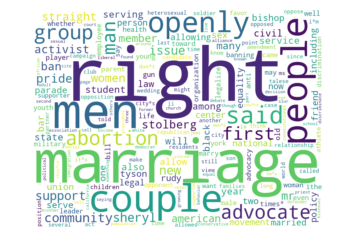

In [49]:
for db in date_bins:
    context = [get_context(toks) for toks in data_yr[db]['toks_nopunct'].tolist()]
    context = [c for c in context if len(c)>0]
    context = [t for d in context for t in d]
    context = ' '.join(context)

    # Remove badlist
    for el in rm_list:
        context = context.replace(el, '')

    wordcloud = WordCloud(height=600, width=800, collocations=False, background_color='white').generate(context)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'/usr0/home/mamille2/11-830_data/lgbtq_context_{db}.png', dpi=200)

# Remove punctuation

In [17]:
# Remove punctuation
lgbtq_data['toks_nopunct'] = lgbtq_data['toks'].map(lambda x: [t for t in x if not t in string.punctuation])
lgbtq_data['toks_nopunct']

0        [re, ûïobama, alters, hospital, rules, for, g...
1        [you, can, not, have, people, who, have, no, e...
2        [in, an, interview, with, tracy, clark, flory,...
3        [after, we, filed, back, out, into, the, tenne...
4        [gays, and, lesbians, are, a, very, good, grou...
5        [the, concept, was, brought, to, the, division...
6        [mr, winslow, urged, any, justice, with, qualm...
7        [to, the, contrary, mr, lieberman, argued, the...
8        [all, this, affirmation, of, existing, hostili...
9        [the, fears, by, gay, priests, and, seminarian...
10       [financial, experts, agree, that, the, most, i...
11       [the, repeal, of, the, out, of, state, marriag...
12       [last, year, for, example, secretary, of, stat...
13       [she, drew, another, ovation, too, with, her, ...
14       [but, many, gay, people, in, their, teens, 20s...
15       [stuart, elliott, the, timesûªs, advertising,...
16       [while, same, sex, marriages, are, forging, ah.

In [27]:
# Remove punctuation
lgbtq_data['tok_pos_nopunct'] = lgbtq_data['tok_pos'].map(lambda x: [t for t in x if not t[0] in string.punctuation])
lgbtq_data['tok_pos_nopunct']

0        [(re, IN), (ûïobama, VBG), (alters, NNS), (ho...
1        [(you, PRP), (can, MD), (not, RB), (have, VB),...
2        [(in, IN), (an, DT), (interview, NN), (with, I...
3        [(after, IN), (we, PRP), (filed, VBD), (back, ...
4        [(gays, NNS), (and, CC), (lesbians, NNS), (are...
5        [(the, DT), (concept, NN), (was, VBD), (brough...
6        [(mr, PRP), (winslow, NN), (urged, VBD), (any,...
7        [(to, IN), (the, DT), (contrary, NN), (mr, NN)...
8        [(all, PDT), (this, DT), (affirmation, NN), (o...
9        [(the, DT), (fears, NNS), (by, IN), (gay, JJ),...
10       [(financial, JJ), (experts, NNS), (agree, VBP)...
11       [(the, DT), (repeal, NN), (of, IN), (the, DT),...
12       [(last, JJ), (year, NN), (for, IN), (example, ...
13       [(she, PRP), (drew, VBD), (another, DT), (ovat...
14       [(but, CC), (many, JJ), (gay, JJ), (people, NN...
15       [(stuart, JJ), (elliott, NN), (the, DT), (time...
16       [(while, IN), (same, JJ), (sex, NN), (marriage.

In [18]:
# Save data
lgbtq_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')

## Lowercase, tokenize

In [7]:
# Load data
# lgbtq_data = pd.read_csv('/home/michael/school/11-830/hw1/lgbt_news_corpus.csv', encoding='ISO-8859-1')
lgbtq_data = pd.read_csv('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.csv', encoding='ISO-8859-1')
print(len(lgbtq_data))
lgbtq_data

34620


/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,8,10,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Text,Title,Id,Count,Date,Category,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Re ÛÏObama Alters Hospital Rules for Gay Righ...,Hospital Visiting Rights for Same-Sex Partners,54457293798810347c1a843e,1,2010-04-26T00:00:00Z,Opinion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,You cannot have people who have no expertise i...,"For Police Union Head, Review Board Proposal I...",4fd1d13d8eb7c8105d70bb37,3,1992-06-28T00:00:00Z,New York and Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,In an interview with Tracy Clark-Flory on Salo...,Why Asexuals DonÛªt Want to Be Invisible Anymore,54232178798810604c505435,4,2014-09-24T15:44:50Z,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,After we filed back out into the Tennessee sun...,"Dollywood: A Little Bit Country, a Little Bit Gay",53f782e67988105a42594f8f,28,2014-08-24T00:00:00Z,Travel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,''Gays and lesbians are a very good group of p...,San Francisco Toasts Gay Weddings,4fd24bb98eb7c8105d7eacb6,20,2004-02-29T00:00:00Z,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,The concept was brought to the division by Mae...,Time Inc. Considers Starting a Magazine for Ga...,4fd1e0ee8eb7c8105d727f1f,1,1994-01-24T00:00:00Z,Business,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Mr. Winslow urged any justice with qualms abou...,"Obey Same-Sex Marriage Law, Officials Told",4fd23c0b8eb7c8105d7d0ed5,2,2004-04-26T00:00:00Z,U.S.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"To the contrary, Mr. Lieberman argued, the law...","To Commit a Hate Crime, Must the Criminal Trul...",548b8e1d79881004157bba6d,18,2007-06-20T00:00:00Z,N.Y. / Region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,All this affirmation of existing hostility mea...,"Don't Ask, Don't Tell, Don't Think",5005d0c21c22dfde670b0b49,2,2012-07-17T16:50:14Z,Opinion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,The fears by gay priests and seminarians inten...,Gay Men Ponder Impact Of Proposal by Vatican,4fd25f7e8eb7c8105d80f225,4,2005-09-23T00:00:00Z,U.S.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Save data
lgbtq_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')

In [55]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [12]:
doc_toks = [nlp(doc.lower()) for doc in tqdm(lgbtq_data['Text'].tolist())]
len(doc_toks)

HBox(children=(IntProgress(value=0, max=34620), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr0/home/mamille2/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



34620

In [17]:
lgbtq_data['toks'] = [[tok.text for tok in doc] for doc in doc_toks]
lgbtq_data['toks'].head()

0    [re, ûïobama, alters, hospital, rules, for, g...
1    [you, can, not, have, people, who, have, no, e...
2    [in, an, interview, with, tracy, clark, -, flo...
3    [after, we, filed, back, out, into, the, tenne...
4    [', ', gays, and, lesbians, are, a, very, good...
Name: toks, dtype: object

In [18]:
lgbtq_data['toks']

0        [re, ûïobama, alters, hospital, rules, for, g...
1        [you, can, not, have, people, who, have, no, e...
2        [in, an, interview, with, tracy, clark, -, flo...
3        [after, we, filed, back, out, into, the, tenne...
4        [', ', gays, and, lesbians, are, a, very, good...
5        [the, concept, was, brought, to, the, division...
6        [mr, ., winslow, urged, any, justice, with, qu...
7        [to, the, contrary, ,, mr, ., lieberman, argue...
8        [all, this, affirmation, of, existing, hostili...
9        [the, fears, by, gay, priests, and, seminarian...
10       [financial, experts, agree, that, the, most, i...
11       [the, repeal, of, the, out, -, of, -, state, m...
12       [last, year, ,, for, example, ,, secretary, of...
13       [she, drew, another, ovation, ,, too, ,, with,...
14       [but, many, gay, people, in, their, teens, ,, ...
15       [stuart, elliott, ,, the, timesûªs, advertisi...
16       [while, same, -, sex, marriages, are, forging,.

In [19]:
# Save data
lgbtq_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')

## Postag

In [31]:
lgbtq_data['spacy_toks'] = [doc.to_bytes() for doc in doc_toks]
lgbtq_data['spacy_toks']

0        b"z\x00\x00\x00\xaf\xff\xff\xff\xf3\xa4'\x95\x...
1        b'8\x01\x00\x00Z\x00\x00\x00 ,\x1c"R\x08\x12\x...
2        b"\x90\x02\x00\x00\xb5\xfd\xff\xff\x802\n\xd87...
3        b'\xf1\x01\x00\x00b\xfe\xff\xff\x1c\xf6M\xa33\...
4        b'\xa7\x00\x00\x00,\x00\x00\x00Y\xb2d\x87\xa6v...
5        b'p\x01\x00\x00\xae\xfe\xff\xff\xbd\xce-q;\xaa...
6        b"L\x00\x00\x00\x12\x00\x00\x002%\xbe\xc4vx\x0...
7        b'#\x01\x00\x00\x0e\xff\xff\xff\x9d\xf6:\xb7\x...
8        b"\xe1\x01\x00\x00c\xfe\xff\xff\\\x8a\xbd\xe0\...
9        b'\xa1\x00\x00\x00(\x00\x00\x00\xed\x8a\xfbR\x...
10       b'@\x02\x00\x00\xf4\xfd\xff\xff! \xe3\x06\\\xb...
11       b"a\x01\x00\x00\xd5\xfe\xff\xff\xbd\xcey\xd4q1...
12       b'\xfc\x00\x00\x00\'\xff\xff\xff\x85_;\x1c\xcf...
13       b'\xd7\x00\x00\x00:\x00\x00\x00\xd9\xda\xd9\xc...
14       b"\xe4\x01\x00\x00|\xfe\xff\xff\xfb\xaf\x1d\x1...
15       b'\x11L\x00\x00W\xbd\xff\xff\xaf?\x9e\xed\x95\...
16       b'\xd1\x00\x00\x007\x00\x00\x00\xb9\xf6\x9bt\x.

In [32]:
# Save data
lgbtq_data.to_pickle('/usr0/home/mamille2/11-830_data/hw1/lgbt_news_corpus.pkl')